In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *

try:
  import gmsh
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
  import gmsh

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!gmsh -2 -format msh2 simple_sym.geo
!dolfin-convert simple_sym.msh lab.xml

In [ ]:
import numpy as np
from sys import argv

# Parámetros
meshName = "lab"
caseDir = "S8"
saveSteps = 10
aspect_hl = 4 # Rel aspecto long. transicion vs altura minima de elemento
l = aspect_hl*7.5e-4 # Longitud de transición

# Material
E = 2450
nu = 0.3
Gc = 0.1 # Energía por unidad de superficie de fractura
g = 9.81
densidad = 1200 * 0.035 # kg/m3 * h = km/m2

# Fzas exteriores
px = 10.
py = 0.

# Condiciones iniciales
w_init = 5e-4
l_init = 0.01
p_init = 10
center = [0.0, 0.0]

# Tolerancias
t = 0
Tfinal = 400
delta_p = 0.1
deltaT = 0.1
tolphi = 1e-3
toldispl = 1e-6
step = 0

## aumentar presión si converge rápido
MAXITE = 5
deltap_counter = 0
DELTAP_AUG = 5

## MESHING ##
mesh = Mesh(meshName+ ".xml")
subdomains = MeshFunction('size_t',mesh,meshName+"_physical_region.xml")
boundary_markers = MeshFunction('size_t',mesh, meshName+"_facet_region.xml")

# 1 . MESH TIENE QUE SER DOMAIN
V = FunctionSpace(mesh, 'CG', 1)
W = VectorFunctionSpace(mesh, 'CG', 1)

qo = 3.4 * (1e-6/60)  # 3.4 ml/min

WW = FunctionSpace(mesh, 'DG', 0)
p, q = TrialFunction(V), TestFunction(V)
u, v = TrialFunction(W), TestFunction(W)

def lame_lambda(E, nu):
    return E*nu / ((1+nu) * (1-2*nu))

def lame_mu(E, nu):
    return E / (2*(1+nu))

lmbda = lame_lambda(E, nu)
mu = lame_mu(E, nu)

def epsilon(u):
  return sym(grad(u))

def sigma(u):
  return 2.0*mu*epsilon(u)+lmbda*tr(epsilon(u))*Identity(len(u))

# Densidad de energia elastica eq (12)
def psi(u):
  return 0.5*(lmbda+mu)*(0.5*(tr(epsilon(u)) + abs(tr(epsilon(u)))))**2 + mu*inner(dev(epsilon(u)), dev(epsilon(u)))

# Parámetro de trayectoria eq (11)
def H(uold, unew, Hold):
  return conditional(lt(psi(uold), psi(unew)), psi(unew), Hold)

class CrackDomain(SubDomain):
  def inside(self, x, on_boundary):
    return abs(x[0] - center[0]) <= l_init and abs(x[1] - center[1]) <= w_init

bcright = DirichletBC(W.sub(0), Constant(0.0), boundary_markers, 10)
bciny = DirichletBC(W.sub(0), Constant(0.0), boundary_markers, 40)

# Aplicar desplazamiento en la dirección y positiva
#load = Expression("t", t=0.0, degree=1)
bcbottom = DirichletBC(W.sub(1), Constant(0.0), boundary_markers, 20)

bc_u = [bcright, bcbottom]#, bciny]

# Condicion de borde de la fractura, se marca la entalla inicial con el valor de 1
crack = CrackDomain()
bc_phi = [DirichletBC(V, Constant(1.0), crack)]

unew, uold, ut = Function(W), Function(W), Function(W, name="displacement")
pnew, pold, Hold, phit = Function(V), Function(V), Function(V), Function(V, name="phi")

# Fzas externas
p_value = p_init
pressure = Constant(p_value)
ds = Measure("ds")(subdomain_data=boundary_markers)
n = FacetNormal(mesh)

# Funcional del desplazamiento eq (x)
txx = Constant((-px, 0.0))
tyy = Constant((0.0, py))
# Funcional del desplazamiento eq (x)
E_du = (1-pold)**2*inner(epsilon(v), sigma(u))*dx + pressure * inner(v, grad(pold))*dx + inner(txx, v) * ds(30) + inner(tyy, v) * ds(50)

# Funcional phi eq (x)
E_phi = (Gc*l*inner(grad(p), grad(q)) + ((Gc/l)+2.0 *H(uold, unew, Hold))*inner(p,q)-2.0*H(uold, unew,Hold)*q)*dx


p_disp = LinearVariationalProblem(lhs(E_du), rhs(E_du), unew, bc_u)
p_phi = LinearVariationalProblem(lhs(E_phi), rhs(E_phi), pnew, bc_phi)

solver_disp = LinearVariationalSolver(p_disp)
solver_phi = LinearVariationalSolver(p_phi)
solver_disp.solve()

os.mkdir(caseDir)

file_results = XDMFFile(f"{caseDir}/{caseDir}.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
fname = open(f"{caseDir}/output.csv", 'w')


while t<=Tfinal:
  step += 1

  deltap_counter += 1 # Si converge sin necesidad de bajar la Presion entonces aceleramos

  if deltap_counter == DELTAP_AUG:
    deltap_counter = 0
    if delta_p < 0.1:
      delta_p = 0.1
      print("Increasing Delta P")
  ## Solve
  t += deltaT
  p_value += delta_p*p_value
  pressure.assign(p_value)

  print(f"Step: {step} Solving for t: {t:.9f} pressure: {p_value:.2f} -----")

  ite = 0
  err_u = 1
  err_phi = 1

  while (err_u > toldispl) or (err_phi > tolphi):
    ite += 1

    if ite % MAXITE == 0:
      p_value *= 0.98
      delta_p = 0.01
      deltap_counter = 0

      pressure.assign(p_value)
      print(f"Disminuir presión a P: {p_value:.2f}")
      # Resetear uold y pold
      uold.assign(ut)
      pold.assign(phit)
      Hold.assign(project(psi(uold), WW))

    solver_disp.solve()
    solver_phi.solve()
    err_u = errornorm(unew, uold, norm_type='l2', mesh=None)
    err_phi = errornorm(pnew, pold, norm_type='l2', mesh=None)
    uold.assign(unew)
    pold.assign(pnew)
    Hold.assign(project(H(uold, unew, Hold), WW))

    print(f"Ite: {ite} -- error phi: {err_phi:.2e} -- error u: {err_u:.2e}" )

  ## Converge
  ut.assign(unew)
  phit.assign(pnew)

  if step%saveSteps == 0:
    file_results.write(ut  , t)
    file_results.write(phit, t)
    print("XMDF Updated")

  fname.write(str(step) + ",")
  fname.write(str(t) + ",")
  fname.write(str(p_value) + "\n")
  #print("Reaccion", reaccion)
  print("Step Converged.")

fname.close()
print("Simulation completed")


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00454879 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.493553 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00924039 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0254807 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cd40aaaf5bc0b68be1a587d7bb9a08da6d0820e7

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00889897 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0214272 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7a8bfae0755f9e3ad929ef760db8e936c1d7e711

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 51
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:         

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00369263 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0142133 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0bb6ea8295a9d49109447a98e18601bb13d2b05f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00525856 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0165005 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00632977 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0140226 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c9ed4701e01cd44ea27ff12e069f04c8038873e2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_35]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0343814 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ea347384b69564a5a733aa56583df9a838734ce5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_23, f_26, f_38]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0567803 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_261eff599b6510fe64bbc1ac1d3f073d660ba191

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    3
  Coefficients:              '[f_23, f_26, f_38]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0600762 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------

Step: 1 Solving for t: 0.100000000 pressure: 11.00 -----
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_a93c00dfb97a21c680985ddd1fece36609e30ca9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.007586 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 1.22248 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
I

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_76fc3cd9625812038c7471125b47cc4c7ae9ad4e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00319791 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0157146 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2768da62f27b11300c2e914d42cbd0f3714ceeaf

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_86]'
  Unique elements:           'Vector<2 x DG4(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x DG4(?,?)>, Vector<2 x CG1(?,?)>, DG4(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0389743 seconds.

INFO:FFC:Compiler stage 2: Comput

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00297713 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0151377 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00780344 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0281489 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8f9acf292fa7994d298cc8c76ab5884f206fd987

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00452924 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.016839 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6b12b35f6826b1a10a79962d0820db31d1390acc

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00512648 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0224082 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.009305 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0130551 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:F

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6ce8a510087f4e034b86fc6d0bf27a775643b273

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_99]'
  Unique elements:           'DG4(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG4(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0398631 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8ef72265d3d7c1326c6f9d09ee77bc2a8983e4a6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'DG0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0279377 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0cef50ccd57d3ff2a8e1828c0c360a5e25dd39c4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00330234 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0147557 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a66ac628399cef3ed97dce589d0731d17967233c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_23, f_26, f_38]'
  Unique elements:           'DG0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'DG0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0474308 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FF

Ite: 1 -- error phi: 7.98e-03 -- error u: 2.55e-02
Ite: 2 -- error phi: 1.48e-04 -- error u: 4.12e-05
Ite: 3 -- error phi: 9.86e-04 -- error u: 4.21e-07
Step Converged.
Step: 2 Solving for t: 0.200000000 pressure: 12.10 -----
Ite: 1 -- error phi: 1.91e-03 -- error u: 2.37e-05
Ite: 2 -- error phi: 6.58e-04 -- error u: 1.78e-05
Ite: 3 -- error phi: 1.70e-03 -- error u: 8.00e-06
Ite: 4 -- error phi: 1.07e-03 -- error u: 2.24e-05
Disminuir presión a P: 11.86
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_2e924d9ea045d2e07621ce4cd3c4eb7c0492550c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_26]'
  Unique elements:           'DG0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0448458 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--------------------

Ite: 5 -- error phi: 1.00e-03 -- error u: 2.34e-05
Ite: 6 -- error phi: 1.40e-06 -- error u: 2.33e-05
Ite: 7 -- error phi: 1.32e-06 -- error u: 1.30e-09
Step Converged.
Step: 3 Solving for t: 0.300000000 pressure: 11.98 -----
Ite: 1 -- error phi: 2.52e-06 -- error u: 1.88e-08
Step Converged.
Step: 4 Solving for t: 0.400000000 pressure: 12.10 -----
Ite: 1 -- error phi: 3.74e-07 -- error u: 2.11e-08
Step Converged.
Step: 5 Solving for t: 0.500000000 pressure: 12.22 -----
Ite: 1 -- error phi: 3.50e-07 -- error u: 2.00e-08
Step Converged.
Step: 6 Solving for t: 0.600000000 pressure: 12.34 -----
Ite: 1 -- error phi: 3.46e-07 -- error u: 2.03e-08
Step Converged.
Increasing Delta P
Step: 7 Solving for t: 0.700000000 pressure: 13.57 -----
Ite: 1 -- error phi: 3.58e-06 -- error u: 2.03e-07
Step Converged.
Step: 8 Solving for t: 0.800000000 pressure: 14.93 -----
Ite: 1 -- error phi: 4.35e-06 -- error u: 2.25e-07
Step Converged.
Step: 9 Solving for t: 0.900000000 pressure: 16.42 -----
Ite: 1 -- e

In [ ]:
!rm -rf /content/S8

In [ ]:
from google.colab import files
!zip -r /content/sample_data.zip /content/S5
files.download('/content/sample_data.zip')

	zip warning: name not matched: /content/lab_21cm

zip error: Nothing to do! (try: zip -r /content/sample_data.zip . -i /content/lab_21cm)


FileNotFoundError: Cannot find file: /content/sample_data.zip

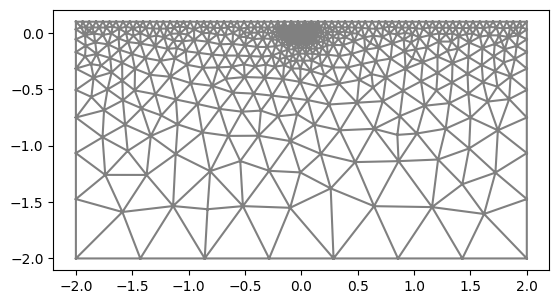

In [ ]:
plot(mesh)